# Imports

In [ ]:
# PyTprch and Transformers installation and import
# These are preinstalled so you will get "Requirement already satisfied" but nevertheless, it is required before you import the relevant packages.
# (not needed for the basic classificaiton models)

! pip install transformers datasets --q
! pip3 install torch --q

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", w

In [ ]:
import os
import csv
import gzip
import tarfile
import zipfile
import time
import logging
import random
import string
from collections import Counter
from functools import partial
from urllib.request import urlretrieve
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import softmax
import nltk
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchtext.utils import reporthook
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
import urllib.request

/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# GloVe

In [ ]:
logger = logging.getLogger(__name__)

def _infer_shape(f):
    num_lines, vector_dim = 0, None
    for line in f:
        if vector_dim is None:
            row = line.rstrip().split(b" ")
            vector = row[1:]
            # Assuming word, [vector] format
            if len(vector) > 2:
                # The header present in some (w2v) formats contains two elements.
                vector_dim = len(vector)
                num_lines += 1  # First element read
        else:
            num_lines += 1
    f.seek(0)
    return num_lines, vector_dim


class Vectors(object):
    def __init__(self, name, cache=None, url=None, unk_init=None, max_vectors=None) -> None:
        """
        Args:

            name: name of the file that contains the vectors
            cache: directory for cached vectors
            url: url for download if vectors not found in cache
            unk_init (callback): by default, initialize out-of-vocabulary word vectors
                to zero vectors; can be any function that takes in a Tensor and returns a Tensor of the same size
            max_vectors (int): this can be used to limit the number of
                pre-trained vectors loaded.
                Most pre-trained vector sets are sorted
                in the descending order of word frequency.
                Thus, in situations where the entire set doesn't fit in memory,
                or is not needed for another reason, passing `max_vectors`
                can limit the size of the loaded set.
        """

        cache = ".vector_cache" if cache is None else cache
        self.itos = None
        self.stoi = None
        self.vectors = None
        self.dim = None
        self.unk_init = torch.Tensor.zero_ if unk_init is None else unk_init
        self.cache(name, cache, url=url, max_vectors=max_vectors)

    def __getitem__(self, token):
        if token in self.stoi:
            return self.vectors[self.stoi[token]]
        else:
            return self.unk_init(torch.Tensor(self.dim))

    def cache(self, name, cache, url=None, max_vectors=None):
        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context
        if os.path.isfile(name):
            path = name
            if max_vectors:
                file_suffix = "_{}.pt".format(max_vectors)
            else:
                file_suffix = ".pt"
            path_pt = os.path.join(cache, os.path.basename(name)) + file_suffix
        else:
            path = os.path.join(cache, name)
            if max_vectors:
                file_suffix = "_{}.pt".format(max_vectors)
            else:
                file_suffix = ".pt"
            path_pt = path + file_suffix

        if not os.path.isfile(path_pt):
            if not os.path.isfile(path) and url:
                logger.info("Downloading vectors from {}".format(url))
                if not os.path.exists(cache):
                    os.makedirs(cache)
                dest = os.path.join(cache, os.path.basename(url))
                if not os.path.isfile(dest):
                    with tqdm(unit="B", unit_scale=True, miniters=1, desc=dest) as t:
                        try:
                            urlretrieve(url, dest, reporthook=reporthook(t))
                        except KeyboardInterrupt as e:  # remove the partial zip file
                            os.remove(dest)
                            raise e
                logger.info("Extracting vectors into {}".format(cache))
                ext = os.path.splitext(dest)[1][1:]
                if ext == "zip":
                    with zipfile.ZipFile(dest, "r") as zf:
                        zf.extractall(cache)
                elif ext == "gz":
                    if dest.endswith(".tar.gz"):
                        with tarfile.open(dest, "r:gz") as tar:
                            tar.extractall(path=cache)
            if not os.path.isfile(path):
                raise RuntimeError("no vectors found at {}".format(path))

            logger.info("Loading vectors from {}".format(path))
            ext = os.path.splitext(path)[1][1:]
            if ext == "gz":
                open_file = gzip.open
            else:
                open_file = open

            vectors_loaded = 0
            with open_file(path, "rb") as f:
                num_lines, dim = _infer_shape(f)
                if not max_vectors or max_vectors > num_lines:
                    max_vectors = num_lines

                itos, vectors, dim = [], torch.zeros((max_vectors, dim)), None

                for line in tqdm(f, total=max_vectors):
                    # Explicitly splitting on " " is important, so we don't
                    # get rid of Unicode non-breaking spaces in the vectors.
                    entries = line.rstrip().split(b" ")

                    word, entries = entries[0], entries[1:]
                    if dim is None and len(entries) > 1:
                        dim = len(entries)
                    elif len(entries) == 1:
                        logger.warning(
                            "Skipping token {} with 1-dimensional " "vector {}; likely a header".format(word, entries)
                        )
                        continue
                    elif dim != len(entries):
                        raise RuntimeError(
                            "Vector for token {} has {} dimensions, but previously "
                            "read vectors have {} dimensions. All vectors must have "
                            "the same number of dimensions.".format(word, len(entries), dim)
                        )

                    try:
                        if isinstance(word, bytes):
                            word = word.decode("utf-8")
                    except UnicodeDecodeError:
                        logger.info("Skipping non-UTF8 token {}".format(repr(word)))
                        continue

                    vectors[vectors_loaded] = torch.tensor([float(x) for x in entries])
                    vectors_loaded += 1
                    itos.append(word)

                    if vectors_loaded == max_vectors:
                        break

            self.itos = itos
            self.stoi = {word: i for i, word in enumerate(itos)}
            self.vectors = torch.Tensor(vectors).view(-1, dim)
            self.dim = dim
            logger.info("Saving vectors to {}".format(path_pt))
            if not os.path.exists(cache):
                os.makedirs(cache)
            torch.save((self.itos, self.stoi, self.vectors, self.dim), path_pt)
        else:
            logger.info("Loading vectors from {}".format(path_pt))
            self.itos, self.stoi, self.vectors, self.dim = torch.load(path_pt)

    def __len__(self):
        return len(self.vectors)

    def get_vecs_by_tokens(self, tokens, lower_case_backup=False):
        """Look up embedding vectors of tokens.

        Args:
            tokens: a token or a list of tokens. if `tokens` is a string,
                returns a 1-D tensor of shape `self.dim`; if `tokens` is a
                list of strings, returns a 2-D tensor of shape=(len(tokens),
                self.dim).
            lower_case_backup : Whether to look up the token in the lower case.
                If False, each token in the original case will be looked up;
                if True, each token in the original case will be looked up first,
                if not found in the keys of the property `stoi`, the token in the
                lower case will be looked up. Default: False.

        Examples:
            >>> examples = ['chip', 'baby', 'Beautiful']
            >>> vec = text.vocab.GloVe(name='6B', dim=50)
            >>> ret = vec.get_vecs_by_tokens(examples, lower_case_backup=True)
        """
        to_reduce = False

        if not isinstance(tokens, list):
            tokens = [tokens]
            to_reduce = True

        if not lower_case_backup:
            indices = [self[token] for token in tokens]
        else:
            indices = [self[token] if token in self.stoi else self[token.lower()] for token in tokens]

        vecs = torch.stack(indices)
        return vecs[0] if to_reduce else vecs

# the original url doesnt work - had to manualy insert a new url that contains the zip file.
# https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
glove_840b300d_URL = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip"
class GloVe(Vectors):
    url = {
        "42B": "http://nlp.stanford.edu/data/glove.42B.300d.zip",
        "840B": glove_840b300d_URL,
        "twitter.27B": "http://nlp.stanford.edu/data/glove.twitter.27B.zip",
        "6B": "http://nlp.stanford.edu/data/glove.6B.zip",
    }

    def __init__(self, name="840B", dim=300, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        super(GloVe, self).__init__(name, url=url, **kwargs)

In [ ]:
glove = GloVe(name='840B', dim=300) # takes about 10 minutes

.vector_cache/glove.840B.300d.zip: 2.18GB [00:20, 104MB/s]                             
100%|█████████▉| 2196017/2196018 [04:44<00:00, 7711.52it/s]


Load data

In [ ]:
train_data_path = '/content/trump_train.tsv'
test_data_path = '/content/trump_tweets_test_a.tsv'

In [ ]:
train_data = pd.read_csv(train_data_path, sep='\\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])

<ipython-input-8-6b5dcf1ae95f>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv(train_data_path, sep='\\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])


In [ ]:
train_data

,tweet_id,user_handle,tweet_text,timestamp,device
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android
...,...,...,...,...,...
3523,722818508665454593,realDonaldTrump,#Trump360 Watch this 360 video of my speech la...,2016-04-20 19:05:36,webClient
3524,722920297393995776,realDonaldTrump,Thank you Indiana! Will be back soon! #Trump20...,2016-04-21 01:50:04,iphone
3525,722967660833722369,realDonaldTrump,Had a meeting with the terrific @GovPenceIN of...,2016-04-21 04:58:17,iphone
3526,722967703313612802,realDonaldTrump,We are going to bring steel and manufacturing ...,2016-04-21 04:58:27,iphone


# Preprocess

In [ ]:
# Convert device column to binary values
def convert_device(df):
    df.loc[df['device'] == 'android', 'device'] = 0
    df.loc[df['device'] != 0, 'device'] = 1
    return df

In [ ]:
# Handle timestamp column by converting to numerical values
def handle_timestamp(df, min_max_scaler):
    def apply_time(data):
        handle_time = lambda x: datetime.strptime(x['timestamp'], '%Y-%m-%d %H:%M:%S').strftime('%Y%m%d')
        try:
            return int(handle_time(data))
        except:
            return None

    df["timestamp"] = min_max_scaler.fit_transform(df.apply(apply_time, axis=1).to_numpy().reshape(-1, 1))
    return df

In [ ]:
# Tokenize tweet text using TweetTokenizer
def tokenize_tweets(df):
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    df["tokens"] = df.apply(lambda x: tweet_tokenizer.tokenize(x.tweet_text), axis=1)
    return df

In [ ]:
# Create additional features from the tweet text
def create_features(df, min_max_scaler):
    count_twit_uppers = lambda x: sum([1 for char in x.tweet_text if char.isupper()])
    df["uppercase_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_uppers, axis=1).to_numpy().reshape(-1, 1))

    count_twit_hash = lambda x: x.tweet_text.count("#")
    df["hashtags_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_hash, axis=1).to_numpy().reshape(-1, 1))

    count_twit_puncts = lambda x: sum([1 for char in x['tweet_text'] if char in string.punctuation])
    df['puncts_counts'] = min_max_scaler.fit_transform(df.apply(count_twit_puncts, axis=1).to_numpy().reshape(-1, 1))

    count_twit_tags = lambda x: x.tweet_text.count("@")
    df["tag_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_tags, axis=1).to_numpy().reshape(-1, 1))

    twitt_len = lambda x: len(x.tokens)
    df["len"] = min_max_scaler.fit_transform(df.apply(twitt_len, axis=1).to_numpy().reshape(-1, 1))

    count_twit_digits = lambda x: sum([char.isdigit() for char in x.tweet_text])
    df["digit_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_digits, axis=1).to_numpy().reshape(-1, 1))

    count_twit_urls = lambda x: x.tweet_text.count("https")
    df["https_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_urls, axis=1).to_numpy().reshape(-1, 1))

    return df

In [ ]:
# Create embeddings for each token in the tweet text
def create_embeddings(df):
    embeddings = []
    for i in range(len(df)):
        embedded_vectors = []
        for token in df.iloc[i].tokens:
            embedded_vectors.append(glove[token])
        embeddings.append(embedded_vectors)  # The list embeddings contains for each row a list of the embedded tokens.
    return embeddings

In [ ]:
# Calculate additional features from the embeddings
def calculate_embedding_features(embeddings, min_max_scaler):
    embedded_features = {}

    sum_tensors = lambda tensor_list: sum(tensor_list)
    summed_embeds = np.array([sum_tensors(lst).numpy() for lst in embeddings])
    embedded_features['summed_embeds'] = summed_embeds

    average_tensors = lambda tensor_list: sum(tensor_list) / len(tensor_list)
    averaged_embeds = np.array([average_tensors(lst).numpy() for lst in embeddings])
    embedded_features['averaged_embeds'] = averaged_embeds

    sum_div_avg_embed = np.divide(summed_embeds, averaged_embeds, where=averaged_embeds != 0)
    embedded_features['sum_div_avg_embed'] = sum_div_avg_embed
    embedded_features['sum_div_avg_embed'] = list(np.where(np.isinf(embedded_features['sum_div_avg_embed']) | np.isnan(embedded_features['sum_div_avg_embed']), 0, embedded_features['sum_div_avg_embed']))
    embedded_features['sum_div_avg_embed'] = min_max_scaler.fit_transform(np.array([sum(lst) / len(lst) for lst in embedded_features['sum_div_avg_embed']]).reshape(-1, 1))

    avg_div_sum = np.divide(averaged_embeds, summed_embeds, where=summed_embeds != 0)
    embedded_features['avg_div_sum'] = avg_div_sum
    embedded_features['avg_div_sum'] = list(np.where(np.isinf(embedded_features['avg_div_sum']) | np.isnan(embedded_features['avg_div_sum']), 0, embedded_features['avg_div_sum']))
    embedded_features['avg_div_sum'] = min_max_scaler.fit_transform(np.array([sum(lst) / len(lst) for lst in embedded_features['avg_div_sum']]).reshape(-1, 1))

    embedded_features['sum_times_avg'] = list(summed_embeds * averaged_embeds)
    embedded_features['summed_embeds'] = list(summed_embeds)
    embedded_features['averaged_embeds'] = list(averaged_embeds)

    return embedded_features

In [ ]:
def preprocess(df, just_df=False, include_vectors=True):

    min_max_scaler = MinMaxScaler()
    df.dropna(inplace=True)  # Drop rows with NaNs
    df = convert_device(df)
    df = handle_timestamp(df, min_max_scaler)
    df = tokenize_tweets(df)
    df = create_features(df, min_max_scaler)
    embeddings = create_embeddings(df)
    embedded_features = calculate_embedding_features(embeddings, min_max_scaler)

    df.rename(columns={'device': 'target'}, inplace=True)
    if just_df:
        return df

    df = df.assign(**embedded_features)  # Adding the embeddings features to the df

    if include_vectors:
        selected_features = ['target', 'uppercase_counts', 'hashtags_counts', 'puncts_counts', 'tag_counts', 'len', 'digit_counts', 'https_counts', 'sum_div_avg_embed', 'avg_div_sum', 'summed_embeds', 'averaged_embeds', 'sum_times_avg']
        tmp = df[selected_features]
        data, labels = tmp[selected_features[1:]], tmp['target']
        tensor_list = []
        vector_cols = ['summed_embeds', 'averaged_embeds', 'sum_times_avg']

        # Iterate over rows in the DataFrame
        for _, row in data.iterrows():
            # Get the numbers and vectors
            numbers = torch.tensor(row.drop(vector_cols).values.astype(np.float32))
            vectors = torch.cat([torch.tensor(v, dtype=torch.float32) for v in row[vector_cols].values])

            # Concatenate the numbers and vectors and add to the list
            tensor_list.append(torch.cat((numbers, vectors)))

        # Stack all tensors in the list into a larger tensor
        final_tensor = torch.stack(tensor_list)

        return final_tensor, labels, data, df, embeddings
    else:
        return df, embeddings

In [ ]:
data_tensors, labels, data, df, embeddings = preprocess(train_data)

**Algorithmic approaches:**



1. [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
2. [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (try both linear and nonlinear kernels!)
3. FFNN classifier - You should use  the PyTorch library to build a FFNN classifier (with at least one hidden layer) to achieve the classification. Feel free to experiment with the number of layers ([a simple tutorial for FFNN with PyTorch](https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb)).
4. A fourth classifier of choice (neural or not). You are encouraged to experiment with classifiers that allow combining different types of features (e.g. number of capitalized words, time of tweeting, etc.)
5. A fifth classifier of your choice  (this should be neural -  RNN, or transformer-based) - feel free to experiment.



# Models

### Logistic Regression

In [ ]:
class CustomLogisticRegression:
    def __init__(self, dataset, target, feature_columns, random_seed=42, split_ratio=0.2):
        self.dataset = dataset
        self.target = target
        self.feature_columns = feature_columns
        self.random_seed = random_seed
        self.split_ratio = split_ratio

    def split_data(self):
        # Split the dataset
        x_train, x_validation, y_train, y_validation = train_test_split(
            self.dataset[self.feature_columns], self.target,
            random_state=self.random_seed, test_size=self.split_ratio
        )

        # Reset indices and ensure correct data types
        self.x_train = x_train.reset_index(drop=True)
        self.x_validation = x_validation.reset_index(drop=True)
        self.y_train = y_train.reset_index(drop=True).astype(int)
        self.y_validation = y_validation.reset_index(drop=True).astype(int)

    def configure_and_train(self):
        # Setup the logistic regression model and grid search parameters
        logistic_model = LogisticRegression(max_iter=300)
        params = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'liblinear', 'lbfgs']}
        self.grid_search = GridSearchCV(logistic_model, params, cv=5)

        # Train the model with grid search
        self.grid_search.fit(self.x_train, self.y_train)
        self.best_model = self.grid_search.best_estimator_

    def evaluate_model(self):
        predictions = self.best_model.predict(self.x_validation)
        print('Optimal Parameters:', self.grid_search.best_params_)
        accuracy = plot_confusion_matrix(self.y_validation.tolist(), predictions, 'Logistic Regression')

        return accuracy

    def predict(self, X):
        return self.best_model.predict(X)

### SVC

In [ ]:
class SupportVectorMachineClassifier:
    def __init__(self, dataset, target, features, random_seed=42, validation_size=0.2):
        self.dataset = dataset
        self.target = target
        self.features = features
        self.random_seed = random_seed
        self.validation_size = validation_size

    def split_data(self):
        # Splitting data
        X_train, X_val, y_train, y_val = train_test_split(
            self.dataset[self.features], self.target,
            random_state=self.random_seed, test_size=self.validation_size
        )

        # Resetting index and converting types
        self.X_train = X_train.reset_index(drop=True)
        self.X_val = X_val.reset_index(drop=True)
        self.y_train = y_train.reset_index(drop=True).astype('int')
        self.y_val = y_val.reset_index(drop=True).astype('int')

    def tune_and_train_model(self):
        # Setting up model and parameter grid
        classifier = SVC()
        parameters = {'C': [1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
        self.grid_search = GridSearchCV(classifier, parameters, cv=5)

        # Fitting the model
        self.grid_search.fit(self.X_train, self.y_train)

        # Best estimator
        self.classifier = self.grid_search.best_estimator_

    def evaluate_model(self):
        y_pred = self.classifier.predict(self.X_val)
        print('Optimal Parameters:', self.grid_search.best_params_)
        accuracy = plot_confusion_matrix(self.y_val.tolist(), y_pred, 'SVM')

        return accuracy

    def predict(self, X):
        return self.classifier.predict(X)

### FFNN

FFNN Dataset

In [ ]:
class FFNNDataset(Dataset):
    def __init__(self, X, labels):
        self.X = X
        self.labels = labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.labels[index]

FFNN Model Class

In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_dim=909, output_dim=1, hidden_layers=[256, 128, 32, 16, 8], dropout_rate=0.3):
        super(FFNN, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Dropout(dropout_rate))

        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_layers[-1], output_dim))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def model_validation_evaluator(self, criterion, data_loader, device=torch.device('cpu')):
        self.eval()
        total_loss = 0.0
        total_correct = []
        elements_count = []
        threshold = 0.5

        with torch.no_grad():
            for X, y in data_loader:
                X, y = X.to(device), y.to(device)
                outputs = self(X).view(-1)
                loss = criterion(outputs, y)
                total_loss += loss.item()

                predicted = (outputs > threshold).float()
                total_correct.append((predicted == y).sum().item())
                elements_count.append(len(y))

        validation_accuracies = [num1 / num2 for num1, num2 in zip(total_correct, elements_count)]
        average_accuracy = sum(validation_accuracies) / len(validation_accuracies)
        average_loss = total_loss / len(data_loader)

        return average_loss, average_accuracy

    def train_weights(self, X_train, X_val, train_y, y_val, criterion, optimizer, num_epochs=32, lr=0.001, batch=32, device=torch.device('cpu')):
        train_dataset = FFNNDataset(X_train, train_y)
        val_dataset = FFNNDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

        stats = {
            'average_epoch_acc': [],
            'validation_accuracy': [],
            'average_accumulated_loss': [],
            'validation_loss': [],
            'training_time': []
        }

        for epoch in range(num_epochs):
            start_time = time.time()
            self.train()

            epoch_accuracy = []
            epoch_accumulated_loss = 0.0

            for X, y in train_loader:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()
                y_preds = self(X).view(-1)
                loss = criterion(y_preds, y)
                loss.backward()
                optimizer.step()

                epoch_accumulated_loss += loss.item()

                # Calculate accuracy
                preds = (y_preds > 0.5).float()
                accuracy = (preds == y).sum().item() / len(y)
                epoch_accuracy.append(accuracy)

            # Validation phase
            validation_loss, validation_accuracy = self.model_validation_evaluator(criterion, val_loader, device)

            # Record statistics
            epoch_time = time.time() - start_time
            average_epoch_acc = sum(epoch_accuracy) / len(epoch_accuracy)
            average_accumulated_loss = epoch_accumulated_loss / len(train_loader)

            stats['average_epoch_acc'].append(average_epoch_acc)
            stats['validation_accuracy'].append(validation_accuracy)
            stats['average_accumulated_loss'].append(average_accumulated_loss)
            stats['validation_loss'].append(validation_loss)
            stats['training_time'].append(epoch_time)

            # Print progress
            print(f"Epoch: {epoch + 1} || Epoch Accuracy: {average_epoch_acc:.5f} || Val Acc: {validation_accuracy:.5f} || "
                  f"Average Accumulated Loss: {average_accumulated_loss:.5f} || Validation Loss: {validation_loss:.5f} || "
                  f"Time Taken: {epoch_time:.5f}")

        return stats

    def predict(self, X, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.eval()
        with torch.no_grad():
            X = torch.Tensor(X).to(device)
            preds = (self(X) > 0.5).float().view(-1)
        return preds

### Random Forest

In [ ]:
class RandomForestModel:
    def __init__(self, data, labels, scalar_features, seed=42):
        self.data = data
        self.labels = labels
        self.scalar_features = scalar_features
        self.seed = seed
        self.model = RandomForestClassifier()
        self.param_grid = {'n_estimators': [10, 30, 50, 100, 256], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 3, 4]}

    def split_data(self):
        X_train, X_val, y_train, y_val = train_test_split(self.data[self.scalar_features], self.labels, random_state=self.seed, test_size=0.2)
        self.X_train = X_train.reset_index(drop=True)
        self.X_val = X_val.reset_index(drop=True)
        self.y_train = y_train.astype('int').reset_index(drop=True)
        self.y_val = y_val.astype('int').reset_index(drop=True)

    def grid_search(self):
        grid_search = GridSearchCV(self.model, self.param_grid, cv=5)
        grid_search.fit(self.X_train, self.y_train)
        self.model = grid_search.best_estimator_
        print('Best Parameters: ', grid_search.best_params_)

    def predict_and_evaluate(self):
        y_pred = self.model.predict(self.X_val)
        accuracy = plot_confusion_matrix(self.y_val.tolist(), y_pred, 'RandomForestClassifier')

        return accuracy

    def predict(self, X):
        return self.model.predict(X)

### Bert

Bert Dataset

In [ ]:
class HFSet(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, is_test=False):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length
        self.is_test = is_test

    def __getitem__(self, idx):
        record = self.data.iloc[idx]
        tweet_text = record['tweet_text']
        encoding = self.tokenize(tweet_text)

        if not self.is_test:
            target = record['target']
            return {
                'input_ids': encoding['input_ids'].view(-1),
                'attention_mask': encoding['attention_mask'].view(-1),
                'label': torch.tensor(int(target), dtype=torch.long)
            }
        else:
            return {
                'input_ids': encoding['input_ids'].view(-1),
                'attention_mask': encoding['attention_mask'].view(-1)
            }

    def __len__(self):
        return self.data.shape[0]

    def tokenize(self, text):
        tokens = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return tokens

Bert Model Class

In [ ]:
class BERTClassifier:
    def __init__(self, model_name, max_length=128, batch_size=64, epochs=7, lr=1e-4, seed=42):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.seed = seed

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

    def prepare_data(self, df):
        X_train, X_val, y_train, y_val = train_test_split(df['tweet_text'], df['target'], random_state=self.seed, test_size=0.2)
        train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
        val_set = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

        train_dataset = HFSet(train_set, self.tokenizer, self.max_length)
        val_dataset = HFSet(val_set, self.tokenizer, self.max_length)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, y_val.values

    def test_data(self, df):
        test_dataset = HFSet(df, self.tokenizer, self.max_length, is_test=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        return test_loader

    def train(self, train_loader):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = torch.nn.CrossEntropyLoss()

        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for batch_data in train_loader:
                attention_mask = batch_data['attention_mask'].to(self.device)
                input_ids = batch_data['input_ids'].to(self.device)
                labels = batch_data['label'].to(self.device)

                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader):.5f}")

    def predict(self, dataloader):
        self.model.eval()
        all_preds = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                all_preds.extend(preds)

        return all_preds

    def run(self, df):
      train_loader, val_loader, y_val = self.prepare_data(df)
      self.train(train_loader)
      preds = self.predict(val_loader)
      y_val = y_val.astype(int)  # Ensure y_val is in integer format
      return y_val, preds

### Plot confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)  # Compute accuracy

    print('Confusion Matrix')
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(cm, cmap='coolwarm')
    fig.colorbar(cax)

    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f'{value}', ha='center', va='center')

    plt.title(f'{title}  Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print('Report:')
    print(classification_report(y_true, y_pred))

    return accuracy  # Return the accuracy

# Train Models

In [ ]:
def training_pipeline(alg, train_fn):
  """Returns a trained model given the specific task and algorithm.
      The pipeline should include all necessary steps that are needed for the
      specified algoritm (preprocessing, normalization, feature extraction - depending
      on your choice and decisions). Obviously, it is advised to implement the pipeline
      through a sequence of function calls.

    Args:

        alg (int): an integer between 1-5, indicating the algorithmic approach as
                    specified above (1: logistic regression, 2: svm, 3:FFNN, etc.).
        train_ fn (str): full path to the file containing the training data.

  """
  scalar_features = ['uppercase_counts',	'hashtags_counts',	'puncts_counts',	'tag_counts',	'len',	'digit_counts',	'https_counts',	'sum_div_avg_embed',	'avg_div_sum']
  train_data = pd.read_csv(train_fn, sep='\\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])
  data_tensors, labels, data, df, embeddings = preprocess(train_data)


  if alg==1:
    log_reg_model = CustomLogisticRegression(data, labels, scalar_features)
    log_reg_model.split_data()
    log_reg_model.configure_and_train()
    return log_reg_model

  elif alg==2:
    svm_classifier = SupportVectorMachineClassifier(data, labels, scalar_features)
    svm_classifier.split_data()
    svm_classifier.tune_and_train_model()
    return svm_classifier

  elif alg==3:
    model = FFNN(input_dim=909, output_dim=1).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(data_tensors, labels, random_state=seed, test_size=0.2)
    y_train = y_train.values.astype(np.float32)
    y_val = y_val.values.astype(np.float32)

    stats = model.train_weights(X_train, X_val, y_train, y_val, criterion, optimizer, num_epochs=32, lr=0.001, batch=32, device=device)
    y_pred = model.predict(X_val, device=device).detach().cpu().numpy()
    return model

  elif alg==4:
    rf_model = RandomForestModel(data, labels, scalar_features)
    rf_model.split_data()
    rf_model.grid_search()
    return rf_model

  elif alg == 5:
    model_name = "kornosk/bert-election2020-twitter-stance-trump-KE-MLM"
    bert_model = BERTClassifier(model_name)
    y_val, preds = bert_model.run(df)
    preds = np.array(preds).astype(int)
    return bert_model

# Get best model

In [ ]:
def retrain_best_model():
  """ Retrains and returns the best performing model for the specified task. The
      function uses the hard coded settings you have found to work best for each
      of the tasks.

      Args:

  """
  best_score = -float('inf')  # Initialize with negative infinity
  train_fn = '/content/trump_train.tsv' # Define the path to the training data

  # Iterate over each algorithm
  for alg in range(1, 6):

      model = training_pipeline(alg, train_fn)

      if alg == 1 or alg == 2:
        accuracy = model.evaluate_model()
      elif alg == 3:
        X_train, X_val, y_train, y_val = train_test_split(data_tensors, labels, random_state=seed, test_size=0.2)
        y_pred = model.predict(X_val).detach().cpu().numpy()
        accuracy = plot_confusion_matrix(y_val.tolist(), y_pred, 'FFNN')
      elif alg == 4:
        accuracy = model.predict_and_evaluate()
      elif alg == 5:
        bert_model = model
        y_val, preds = bert_model.run(df)
        accuracy = plot_confusion_matrix(y_val, preds, 'Bert')

      print(f"The accuracy of the selected model: {accuracy}")

      # Compare scores to find the best model
      if accuracy > best_score:
          best_score = accuracy
          m = model

  return m

# Predict

In [ ]:
def predict(m, fn):
  """ Returns a list of 0s and 1s, corresponding to the lines in the specified file.

    Args:
      m: the trained model to be used.
      fn: the full path to a file in the same format as the test set we have proveded.
  """
  # Load the test data
  test_data = pd.read_csv(fn, sep='\\t', names=['user_handle', 'tweet_text', 'timestamp'])
  print(f"Number of test samples: {len(test_data)}")
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  test_loader = m.test_data(test_data)
  res = m.predict(test_loader)
  print(f"Number of predictions: {len(res)}")

  # Convert predictions to list of 0s and 1s
  res = [int(pred) for pred in res]

  return res #a list containing the predictions

# Results

<ipython-input-26-0e8ef4f9a7e8>:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv(train_fn, sep='\\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])


Optimal Parameters: {'C': 10, 'solver': 'newton-cg'}
Confusion Matrix


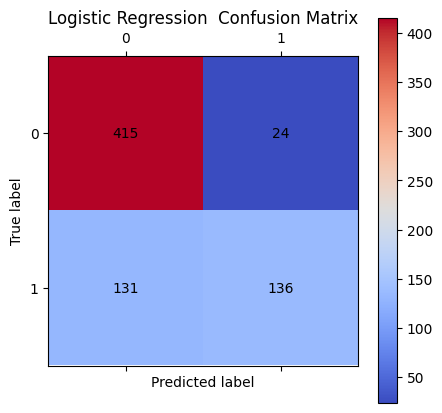

Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       439
           1       0.85      0.51      0.64       267

    accuracy                           0.78       706
   macro avg       0.81      0.73      0.74       706
weighted avg       0.79      0.78      0.76       706

The accuracy of the selected model: 0.7804532577903682


<ipython-input-26-0e8ef4f9a7e8>:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv(train_fn, sep='\\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])


Optimal Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Confusion Matrix


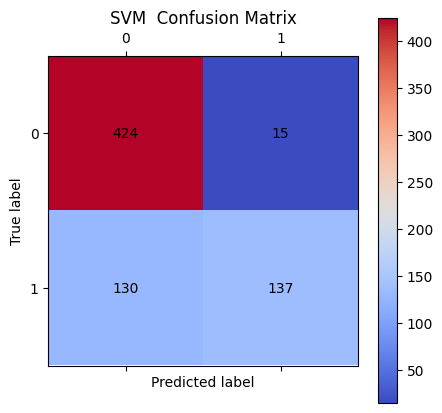

Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.85       439
           1       0.90      0.51      0.65       267

    accuracy                           0.79       706
   macro avg       0.83      0.74      0.75       706
weighted avg       0.82      0.79      0.78       706

The accuracy of the selected model: 0.7946175637393768


<ipython-input-26-0e8ef4f9a7e8>:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv(train_fn, sep='\\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])


Epoch: 1 || Epoch Accuracy: 0.64408 || Val Acc: 0.63723 || Average Accumulated Loss: 0.69786 || Validation Loss: 0.67568 || Time Taken: 1.28889
Epoch: 2 || Epoch Accuracy: 0.64150 || Val Acc: 0.63723 || Average Accumulated Loss: 0.67404 || Validation Loss: 0.67257 || Time Taken: 0.27906
Epoch: 3 || Epoch Accuracy: 0.68247 || Val Acc: 0.72418 || Average Accumulated Loss: 0.66577 || Validation Loss: 0.66659 || Time Taken: 0.28915
Epoch: 4 || Epoch Accuracy: 0.76498 || Val Acc: 0.69837 || Average Accumulated Loss: 0.64928 || Validation Loss: 0.67099 || Time Taken: 0.28654
Epoch: 5 || Epoch Accuracy: 0.76358 || Val Acc: 0.78261 || Average Accumulated Loss: 0.64920 || Validation Loss: 0.64354 || Time Taken: 0.27982
Epoch: 6 || Epoch Accuracy: 0.76299 || Val Acc: 0.76223 || Average Accumulated Loss: 0.64920 || Validation Loss: 0.64740 || Time Taken: 0.27706
Epoch: 7 || Epoch Accuracy: 0.77961 || Val Acc: 0.77038 || Average Accumulated Loss: 0.64543 || Validation Loss: 0.64548 || Time Taken: 

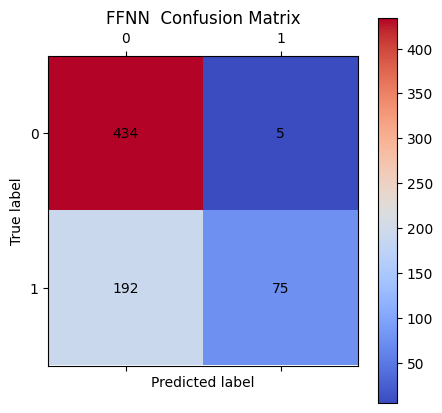

Report:
              precision    recall  f1-score   support

           0       0.69      0.99      0.82       439
           1       0.94      0.28      0.43       267

    accuracy                           0.72       706
   macro avg       0.82      0.63      0.62       706
weighted avg       0.79      0.72      0.67       706

The accuracy of the selected model: 0.7209631728045326


<ipython-input-26-0e8ef4f9a7e8>:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv(train_fn, sep='\\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])


Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 256}
Confusion Matrix


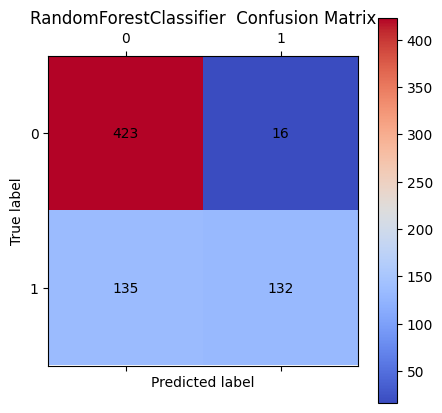

Report:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       439
           1       0.89      0.49      0.64       267

    accuracy                           0.79       706
   macro avg       0.82      0.73      0.74       706
weighted avg       0.81      0.79      0.77       706

The accuracy of the selected model: 0.7861189801699717


<ipython-input-26-0e8ef4f9a7e8>:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv(train_fn, sep='\\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/478 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch 1, Average Loss: 0.41912
Epoch 2, Average Loss: 0.26579
Epoch 3, Average Loss: 0.16084
Epoch 4, Average Loss: 0.08068
Epoch 5, Average Loss: 0.05920
Epoch 6, Average Loss: 0.03308
Epoch 7, Average Loss: 0.05091
Epoch 1, Average Loss: 0.03552
Epoch 2, Average Loss: 0.02592
Epoch 3, Average Loss: 0.02981
Epoch 4, Average Loss: 0.01993
Epoch 5, Average Loss: 0.02636
Epoch 6, Average Loss: 0.01003
Epoch 7, Average Loss: 0.00571
Confusion Matrix


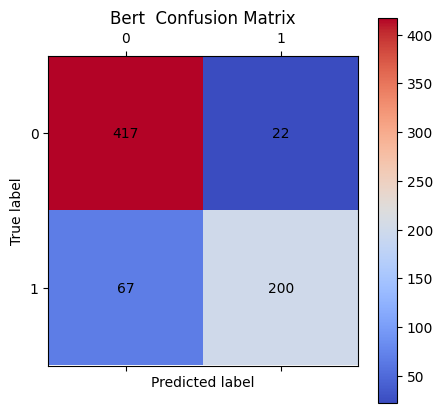

Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       439
           1       0.90      0.75      0.82       267

    accuracy                           0.87       706
   macro avg       0.88      0.85      0.86       706
weighted avg       0.88      0.87      0.87       706

The accuracy of the selected model: 0.8739376770538244


In [ ]:
best_model = retrain_best_model()

In [ ]:
best_model

In [ ]:
test_data = pd.read_csv('/content/trump_tweets_test_a.tsv', sep='\\t', names=['user_handle', 'tweet_text', 'timestamp'])
test_data

<ipython-input-31-0effe6a53cca>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_data = pd.read_csv('/content/trump_tweets_test_a.tsv', sep='\\t', names=['user_handle', 'tweet_text', 'timestamp'])


,user_handle,tweet_text,timestamp
0,realDonaldTrump,.@HillaryClinton is weak on illegal immigratio...,2015-11-20 23:38:57
1,realDonaldTrump,Via Morning Consult: New Poll has me leading.....,2015-09-22 16:51:55
2,realDonaldTrump,"New York Yankees President, Randy Levine: 'End...",2016-04-29 07:08:34
3,realDonaldTrump,Give the public a break - The FAKE NEWS media ...,2017-02-20 16:15:42
4,realDonaldTrump,Ohio Gov. Kasich voted for NAFTA from which Oh...,2016-03-13 13:33:52
...,...,...,...
195,realDonaldTrump,"""@jojo2foxy: TRUMP IS UNSTOPPABLE....HE IS WHA...",2016-02-23 17:38:24
196,realDonaldTrump,Heading to D.C. to see and hear ROLLING THUNDE...,2016-05-29 19:45:44
197,realDonaldTrump,I will be interviewed on @Morning_Joe at 7:00 ...,2015-10-27 12:48:32
198,realDonaldTrump,FLORIDA: Do not miss this opportunity to #Make...,2016-03-06 17:43:39


In [ ]:
fn = '/content/trump_tweets_test_a.tsv'
predictions = predict(best_model, fn)

Number of test samples: 200


<ipython-input-28-2c1a62e2813e>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_data = pd.read_csv(fn, sep='\\t', names=['user_handle', 'tweet_text', 'timestamp'])


Number of predictions: 200


In [ ]:
# Save the predictions to a file
with open('313689804_207653312_aa.txt', 'w') as f:
  f.write(' '.join(map(str, predictions)))

In [ ]:
def who_am_i():  # this is not a class method
    """Returns a ductionary with your name, id number and email. keys=['name', 'id','email']
        Make sure you return your own info!
    """
    return {'name': 'Lina Golan, Noi Kogman', 'id': '313689804, 207653312', 'email': 'linago@post.bgu.ac.il, kogmann@post.bgu.ac.il'}